# Import Libraries

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

print("NoProp Time Series Forecasting Notebook")

NoProp Time Series Forecasting Notebook


# Hyperparameters

In [67]:
T = 8  # Diffusion steps
embed_dim = 32  # Target embedding dimension for time series
batch_size = 64
lr = 0.001
epochs = 50
seq_len = 24  # Input sequence length
pred_len = 12  # Prediction horizon
hidden_dim = 64

# Noise Schedule

In [68]:
# Noise schedule (linear)
alpha = torch.linspace(0.9, 0.2, T+1)
alpha_bar = torch.cumprod(alpha.flip(0), dim=0).flip(0)
SNR = alpha_bar / (1 - alpha_bar)

# Compute a_t, b_t, c_t
alpha_bar_prev = torch.cat([torch.tensor([torch.nan]), alpha_bar[:-1]])
alpha_prev = torch.cat([torch.tensor([torch.nan]), alpha[:-1]])

a = torch.sqrt(alpha_bar) * (1 - alpha_prev) / (1 - alpha_bar_prev)
b = torch.sqrt(alpha_bar_prev) * (1 - alpha_bar) / (1 - alpha_bar_prev)
c = (1 - alpha_bar) * (1 - alpha_prev) / (1 - alpha_bar_prev)

print("SNR:", SNR)
print("a_t:", a)
print("b_t:", b)
print("c_t:", c)

SNR: tensor([0.0019, 0.0021, 0.0025, 0.0035, 0.0055, 0.0101, 0.0220, 0.0610, 0.2500])
a_t: tensor([   nan, 0.0045, 0.0095, 0.0163, 0.0269, 0.0452, 0.0797, 0.1532, 0.3381])
b_t: tensor([   nan, 0.0430, 0.0454, 0.0503, 0.0590, 0.0737, 0.0987, 0.1414, 0.2035])
c_t: tensor([   nan, 0.1000, 0.1874, 0.2747, 0.3618, 0.4480, 0.5312, 0.6020, 0.6048])


# Setting Up Models

In [ ]:
class TimeSeriesBlock(nn.Module):
    def __init__(self, seq_len, pred_len, embed_dim, hidden_dim=64):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len

        # Handles input sequence
        self.temporal_encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(hidden_dim),
            nn.Flatten(),
            nn.Linear(32 * hidden_dim, hidden_dim)
        )

        # Handles previous layer activation
        self.embedding_processor = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

    def forward(self, x_seq, z_t):
        x_reshaped = x_seq.unsqueeze(1)  # (batch, 1, seq_len)
        temporal_features = self.temporal_encoder(x_reshaped)
        embed_features = self.embedding_processor(z_t)
        combined = torch.cat([temporal_features, embed_features], dim=1)
        return self.predictor(combined)

class TargetEncoder(nn.Module):
    def __init__(self, pred_len, embed_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(pred_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )
    def forward(self, y):
        return self.encoder(y)

class TargetDecoder(nn.Module):
    def __init__(self, embed_dim, pred_len):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, pred_len)
        )
    def forward(self, z):
        return self.decoder(z)

# Initialize models
blocks = nn.ModuleList([None] + [TimeSeriesBlock(seq_len, pred_len, embed_dim, hidden_dim) for _ in range(T)])
target_encoder = TargetEncoder(pred_len, embed_dim)
target_decoder = TargetDecoder(embed_dim, pred_len)

# Optimizers
optimizers = [optim.Adam(blocks[i].parameters(), lr=lr) for i in range(1, T+1)]
encoder_optimizer = optim.Adam(target_encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(target_decoder.parameters(), lr=lr)

total_params = (
    sum(p.numel() for p in blocks.parameters() if p is not None)
    + sum(p.numel() for p in target_encoder.parameters())
    + sum(p.numel() for p in target_decoder.parameters())
)
print(f"Model parameters (total): {total_params}")

Model parameters (total): 1332908


# Preparing Dataset

In [70]:
def generate_synthetic_data(n_samples=5000):
    np.random.seed(42)
    t = np.linspace(0, 4*np.pi, seq_len + pred_len)
    data = []
    for _ in range(n_samples):
        trend = np.random.randn() * 0.5 * t
        seasonal = np.random.randn() * np.sin(t * np.random.uniform(1, 3))
        noise = np.random.randn(len(t)) * 0.1
        series = trend + seasonal + noise
        data.append(series)
    data = np.array(data)
    scaler = StandardScaler()
    data = scaler.fit_transform(data.T).T
    X = data[:, :seq_len].astype(np.float32)
    Y = data[:, seq_len:].astype(np.float32)
    return X, Y, scaler

print("Generating synthetic time series data...")
X_train, Y_train, scaler = generate_synthetic_data(5000)
X_test, Y_test, _ = generate_synthetic_data(1000)

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")

Generating synthetic time series data...
Train samples: 5000 | Test samples: 1000


# Training

In [71]:
print("Starting training...")
train_losses = []
test_losses = []

# Track per-block (1..T) avg weighted MSE loss per epoch
block_loss_history = [[] for _ in range(T)]

for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0
    # accumulate weighted MSE per block over batches
    epoch_block_loss_sums = [0.0] * T

    for x_batch, y_batch in train_loader:
        u_y = target_encoder(y_batch)

        # Forward diffusion for target embeddings
        z = [torch.randn_like(u_y)]  # z_0: pure noise
        for t in range(1, T + 1):
            eps = torch.randn_like(u_y)
            z_t = torch.sqrt(alpha_bar[t]) * u_y + torch.sqrt(1 - alpha_bar[t]) * eps
            z.append(z_t)

        losses = []

        # Blocks 1..T
        for t in range(1, T+1):
            u_hat_t = blocks[t](x_batch, z[t-1].detach())
            block_loss = (SNR[t] - SNR[t-1]) * torch.mean((u_hat_t - u_y) ** 2)
            losses.append(block_loss)
            epoch_block_loss_sums[t-1] += block_loss.item()

        # Final block and reconstruction
        y_pred = target_decoder(z[T])
        reconstruction_loss = F.mse_loss(y_pred, y_batch)
        losses.append(reconstruction_loss)

        # Encoder/decoder consistency
        y_reconstructed = target_decoder(target_encoder(y_batch))
        consistency_loss = F.mse_loss(y_reconstructed, y_batch)
        losses.append(consistency_loss)

        total_loss = sum(losses)

        for opt in optimizers:
            opt.zero_grad()
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        total_loss.backward()

        for opt in optimizers:
            opt.step()
        encoder_optimizer.step()
        decoder_optimizer.step()

        epoch_loss += total_loss.item()
        batch_count += 1

    # Evaluation
    test_loss = 0.0
    test_batches = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            z_t = torch.randn(xb.shape[0], embed_dim)
            for t in range(1, T+1):
                u_hat = blocks[t](xb, z_t)
                z_t = a[t] * u_hat + b[t] * z_t + torch.sqrt(c[t]) * torch.randn_like(u_hat)
            yp = target_decoder(z_t)
            test_loss += F.mse_loss(yp, yb).item()
            test_batches += 1

    # Store per-block epoch averages
    epoch_block_loss_avgs = [s / batch_count for s in epoch_block_loss_sums]
    for i, v in enumerate(epoch_block_loss_avgs):
        block_loss_history[i].append(v)

    avg_train_loss = epoch_loss / batch_count
    avg_test_loss = test_loss / test_batches
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")

print("Training complete!")

Starting training...
Epoch 5/50 | Train Loss: 0.3425 | Test Loss: 0.3336
Epoch 5/50 | Train Loss: 0.3425 | Test Loss: 0.3336
Epoch 10/50 | Train Loss: 0.2226 | Test Loss: 0.2198
Epoch 10/50 | Train Loss: 0.2226 | Test Loss: 0.2198
Epoch 15/50 | Train Loss: 0.1933 | Test Loss: 0.1800
Epoch 15/50 | Train Loss: 0.1933 | Test Loss: 0.1800
Epoch 20/50 | Train Loss: 0.1740 | Test Loss: 0.1673
Epoch 20/50 | Train Loss: 0.1740 | Test Loss: 0.1673
Epoch 25/50 | Train Loss: 0.1603 | Test Loss: 0.1406
Epoch 25/50 | Train Loss: 0.1603 | Test Loss: 0.1406
Epoch 30/50 | Train Loss: 0.1495 | Test Loss: 0.1314
Epoch 30/50 | Train Loss: 0.1495 | Test Loss: 0.1314
Epoch 35/50 | Train Loss: 0.1403 | Test Loss: 0.1207
Epoch 35/50 | Train Loss: 0.1403 | Test Loss: 0.1207
Epoch 40/50 | Train Loss: 0.1325 | Test Loss: 0.1116
Epoch 40/50 | Train Loss: 0.1325 | Test Loss: 0.1116
Epoch 45/50 | Train Loss: 0.1284 | Test Loss: 0.1072
Epoch 45/50 | Train Loss: 0.1284 | Test Loss: 0.1072
Epoch 50/50 | Train Loss: 0

## Visualization: Final Loss and Sample Predictions

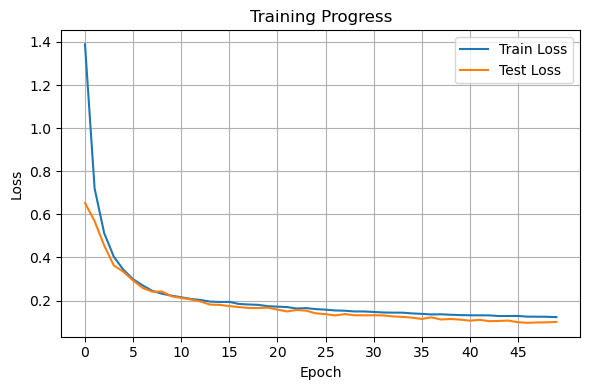

In [84]:
# Loss curves only
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# set x ticks every 5 epochs
plt.xticks(range(0, len(train_losses), 5))

plt.tight_layout()
plt.show()


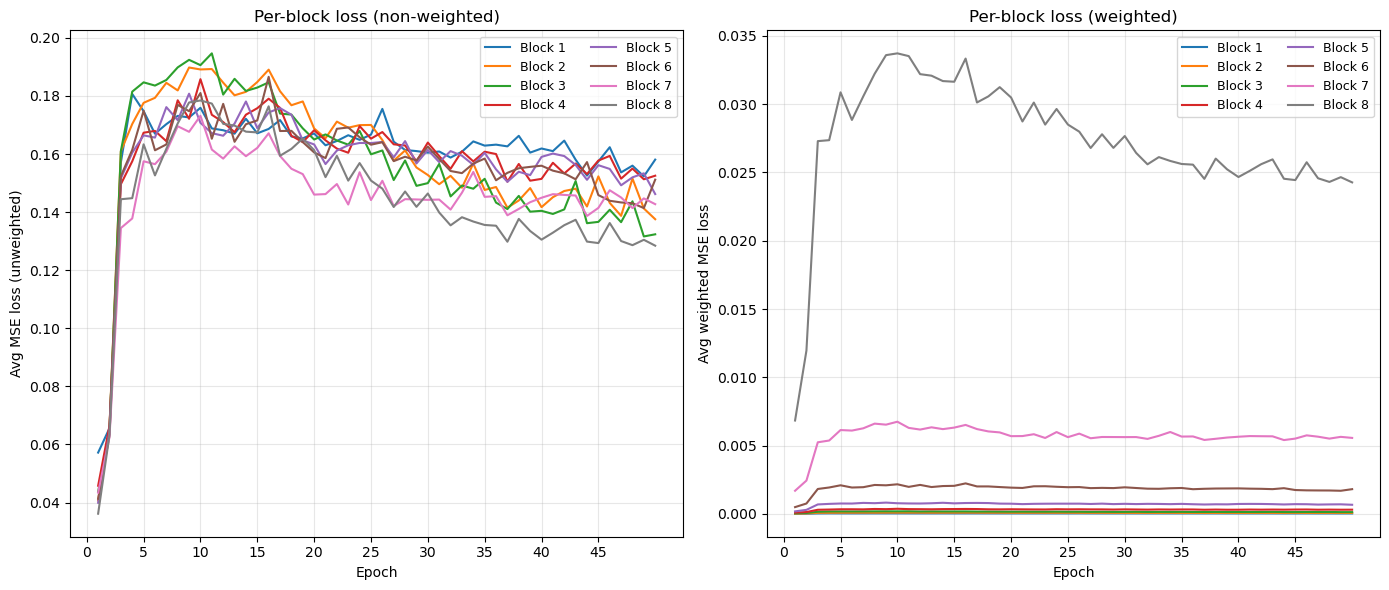

In [85]:
epochs_axis = list(range(1, len(block_loss_history[0]) + 1))
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Left: non-weighted MSE (normalize by the block weight)
for i in range(T):
    denom = (SNR[i+1] - SNR[i]).item()  # scalar
    non_weighted = np.array(block_loss_history[i]) / denom
    axes[0].plot(epochs_axis, non_weighted, label=f"Block {i+1}")
    axes[1].plot(epochs_axis, block_loss_history[i], label=f"Block {i+1}")

for ax in axes:
    ax.set_xlabel("Epoch")
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, len(train_losses), 5))
    ax.legend(ncol=2, fontsize=9)

axes[0].set_ylabel("Avg MSE loss (unweighted)")
axes[0].set_title("Per-block loss (non-weighted)")
axes[1].set_ylabel("Avg weighted MSE loss")
axes[1].set_title("Per-block loss (weighted)")

plt.tight_layout()
plt.show()

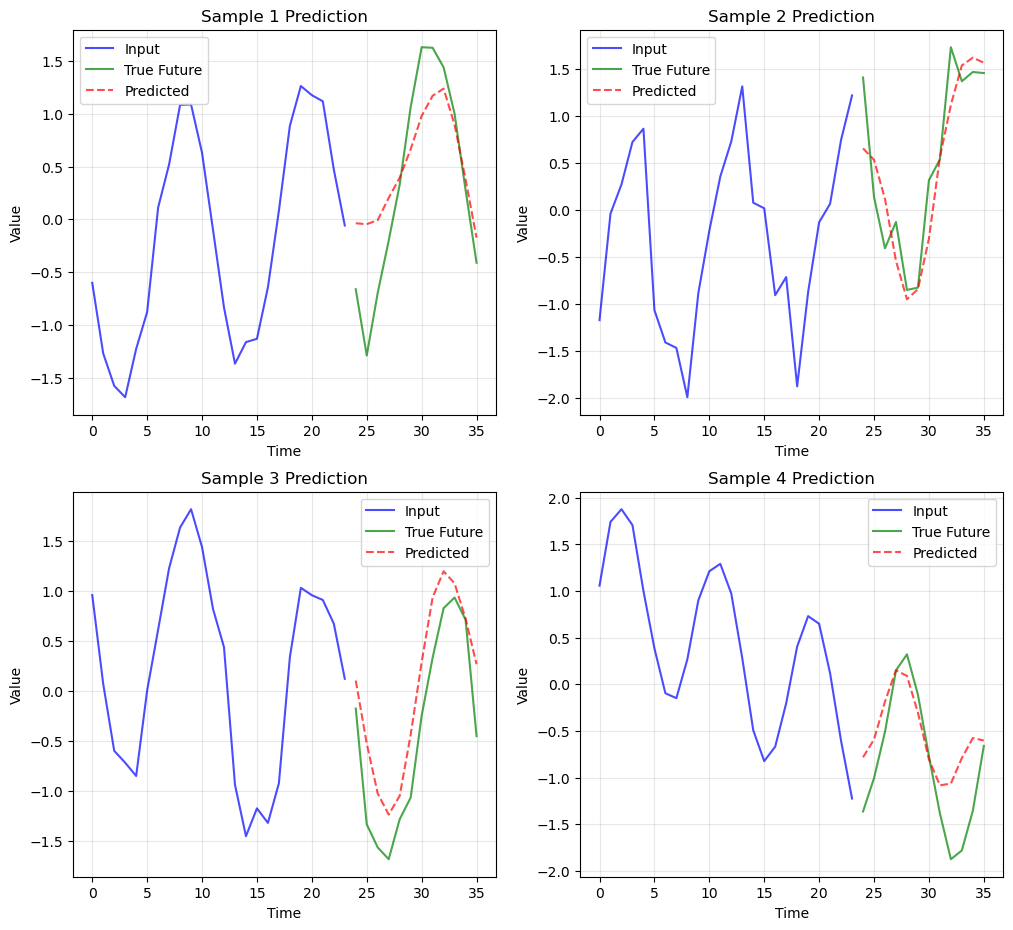

In [86]:
# Sample predictions only
def predict_sequence(x):
    with torch.no_grad():
        x_tensor = torch.tensor(x).unsqueeze(0)
        z_t = torch.randn(1, embed_dim)
        for t in range(1, T+1):
            u_hat = blocks[t](x_tensor, z_t)
            z_t = a[t] * u_hat + b[t] * z_t + torch.sqrt(c[t]) * torch.randn_like(u_hat)
        y_pred = target_decoder(z_t)
        return y_pred.squeeze().numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 11))

# Sample predictions (from test set)
for idx, ax in enumerate([axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]]):
    sample_idx = np.random.randint(0, len(X_test))
    x_sample = X_test[sample_idx]
    y_true = Y_test[sample_idx]
    y_pred = predict_sequence(x_sample)
    time_input = np.arange(seq_len)
    time_pred = np.arange(seq_len, seq_len + pred_len)
    ax.plot(time_input, x_sample, 'b-', label='Input', alpha=0.7)
    ax.plot(time_pred, y_true, 'g-', label='True Future', alpha=0.7)
    ax.plot(time_pred, y_pred, 'r--', label='Predicted', alpha=0.7)
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.set_title(f'Sample {idx+1} Prediction')
    ax.legend()
    ax.grid(True, alpha=0.3)

## Final evaluation

In [74]:
mse_scores = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        z_t = torch.randn(x_batch.shape[0], embed_dim)
        for t in range(1, T+1):
            u_hat = blocks[t](x_batch, z_t)
            z_t = a[t] * u_hat + b[t] * z_t + torch.sqrt(c[t]) * torch.randn_like(u_hat)
        y_pred = target_decoder(z_t)
        mse = F.mse_loss(y_pred, y_batch, reduction='none').mean(dim=1)
        mse_scores.extend(mse.numpy())

print(f"Final Test MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
print(f"Median Test MSE: {np.median(mse_scores):.4f}")

Final Test MSE: 0.1021 ± 0.0911
Median Test MSE: 0.0753
